In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import popoff
from Session import SessionLite
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder
import loadpaths
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
from scipy import stats, signal
import statsmodels.api as sm

from IPython.core.debugger import Pdb
ipdb = Pdb()

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [4]:
user_paths = loadpaths.loadpaths()
sys.path.append(user_paths['base_path'])
from pySpatialNeuronNet import factor_analysis

ModuleNotFoundError: No module named 'pySpatialNeuronNet'

In [3]:
plt.style.use("dark_background")

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]

## Load Both PoolAcrossSessions class and example LinearModel class
* PoolAcrossSessions loads 4 example sessions and has an attribute 'linear_models', a list of len n_sessions containing a LinearModel object for every session
* The PoolAcrossSessions class has methods that match the methods in LinearModel, producing the same plots across sessions
* PAS also computes PC array for each session and saves it into the object. This can be recomputed by setting save_PCA=True.


In [4]:
remove_targets = True
pas = PoolAcrossSessions(save_PCA=False, remove_targets=remove_targets)

In [5]:
# session = pas.sessions[5]  # Example session for some plots
lm = pas.linear_models[1]
lm.session

instance Mouse J064, run 10 of Session class

 Cell included from region s1


({'all_covs': [0.7692307692307693,
   0.75,
   0.5714285714285714,
   0.8333333333333334,
   0.6410256410256411],
  'mean_pre': [0.8846153846153846,
   0.6730769230769231,
   0.2619047619047619,
   0.8333333333333334,
   0.6410256410256411],
  'corr_pre': [0.7307692307692308,
   0.75,
   0.5714285714285714,
   0.8333333333333334,
   0.6410256410256411],
  'largest_singular_value': [0.7692307692307692,
   0.8269230769230769,
   0.6190476190476191,
   0.761904761904762,
   0.6923076923076923],
  'ts_s1_pre': [0.8269230769230769,
   0.7692307692307692,
   0.6428571428571429,
   0.9047619047619049,
   0.6410256410256411],
  'shuffled_null': [0.523809523809524,
   0.7142857142857144,
   0.5576923076923077,
   0.5384615384615384,
   0.5384615384615385]},
 [array([ 0.83058415,  0.        , -0.28206453, -0.04346749]),
  array([ 0.60206039,  0.        , -0.67599417, -0.16593419]),
  array([ 0.49108569, -0.01165304, -0.62296104, -0.54953143]),
  array([ 0.65031263,  0.01459406, -0.38171191, -0.4

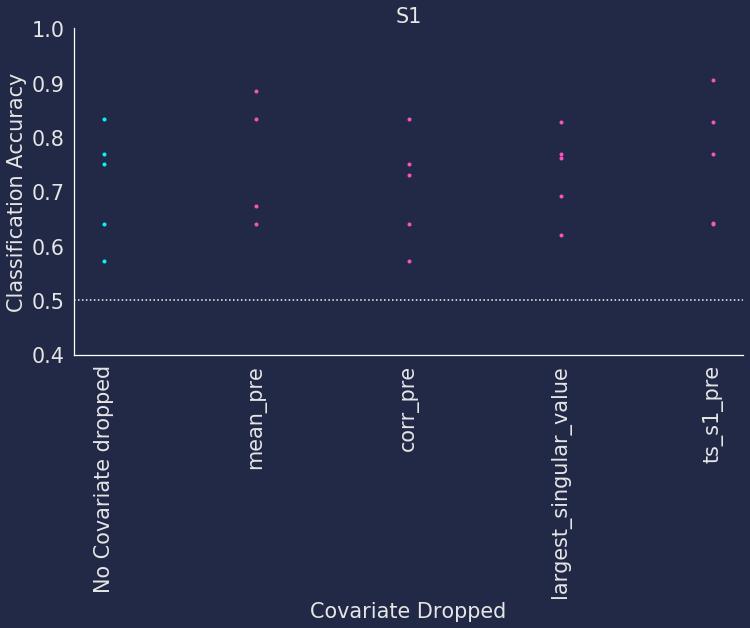

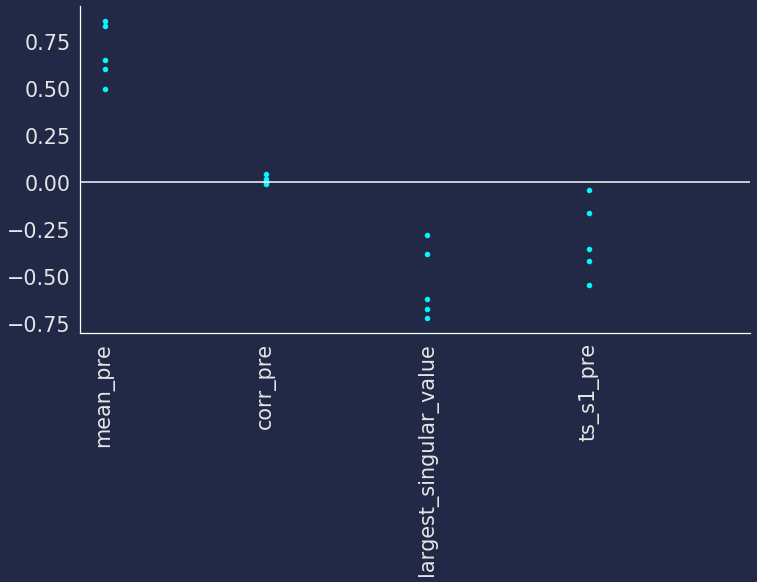

In [7]:
lm.dropout(region='s1')

 Cell included from region s2
 Cell included from region s2
 Cell included from region s2


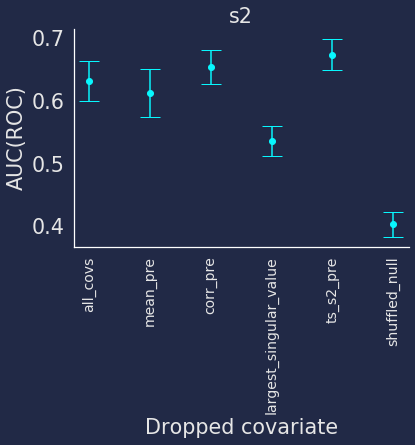

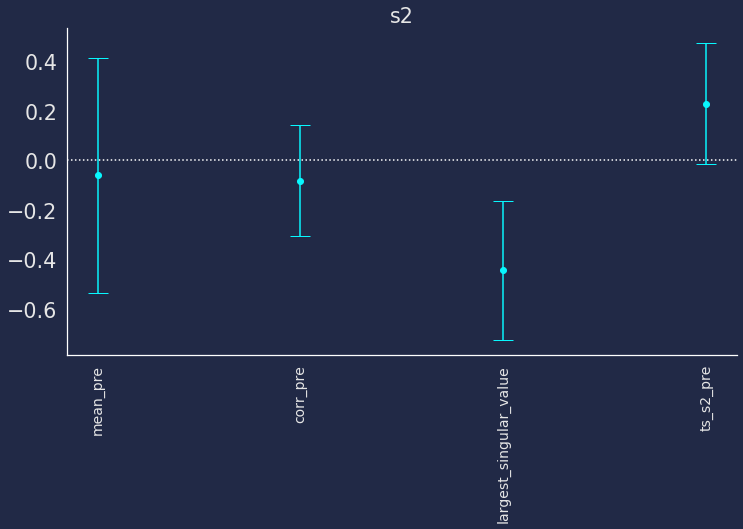

In [24]:
pas.dropout(region='s2')

 Cell included from region s1


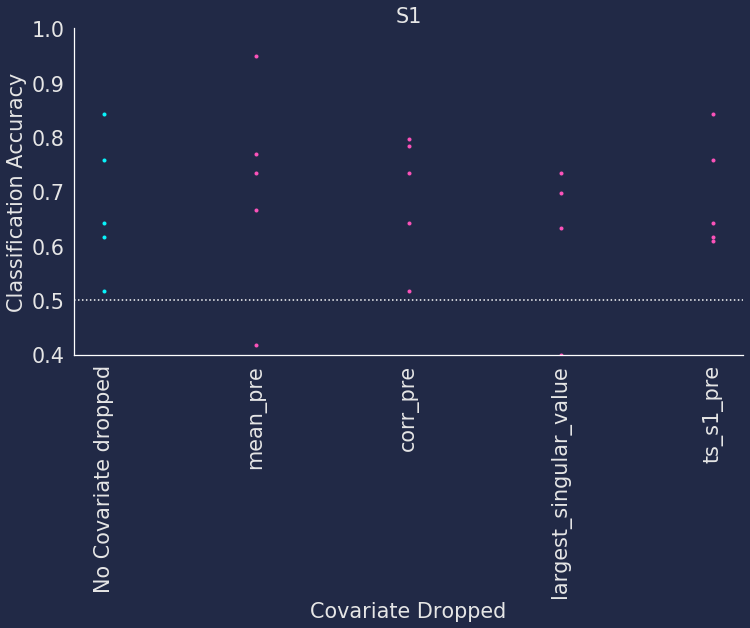

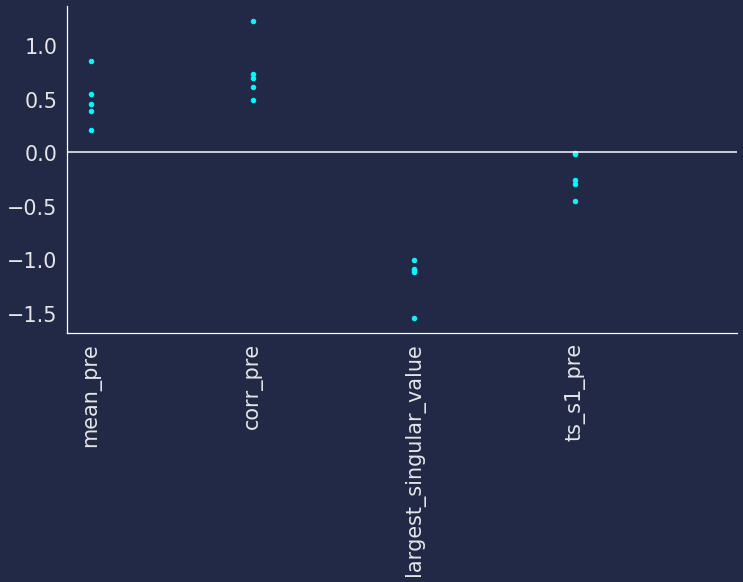

In [29]:
lm = pas.linear_models[2]
_ = lm.dropout('s1')

 Cell included from region s2
 Cell included from region s2
 Cell included from region s2


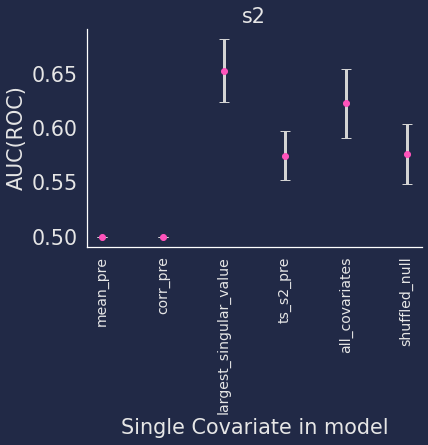

In [26]:
pas.single_covariate(region='s2')

## Model is able to switch between binary classification and multiclass.
### Below is just results of the multiclass model
### First plot the full model performance as a function of regularisation strength

In [178]:
# lm.model_params_plot(outcomes=['hit', 'miss', 'fp', 'cr'])

## Performance of partial model as a function of sequentially added covariates

 Cell included from region all


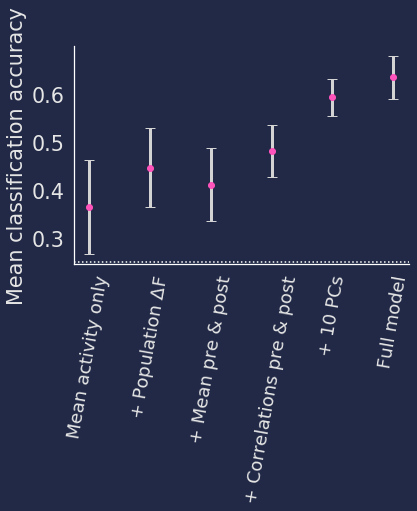

In [59]:
_ = lm.partial_model_performance('all', multiclass=True)

 Cell included from region all
 Cell included from region all


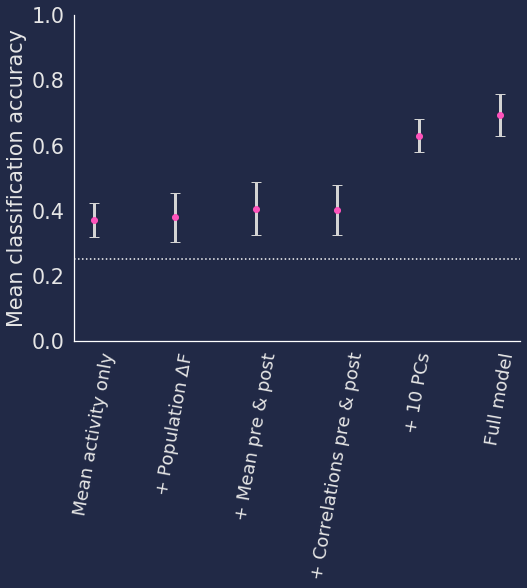

In [60]:
pas.partial_model_performance('all', multiclass=True)

## Examine betas of the partial model for different trial types

# Is it that on hit trials they are particularly correlated?
# Or is it that the hittiest components are generally correlated

## Need to figure out whether I can about scale or not -> J048 run 30, comp 0 -> the components are very simliar if you rescale them, but different if you don't. 
### So the e.g. pearson's is high but the rmse between the two is different, probably need to know what Zylberberg mean by matching the informative correlations


 Cell included from region s1


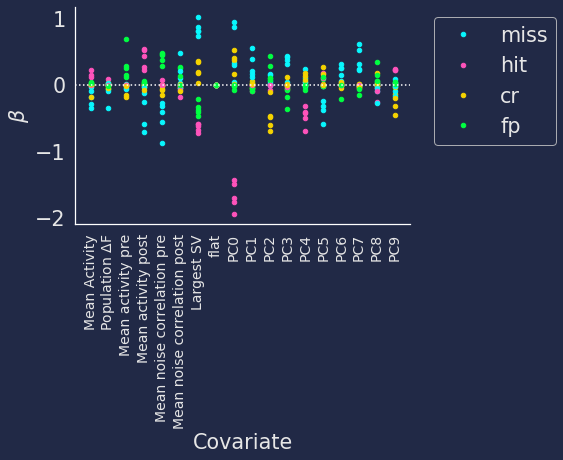

In [61]:
# For a single session
# S1
coefs_s1, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s1')

 Cell included from region s2


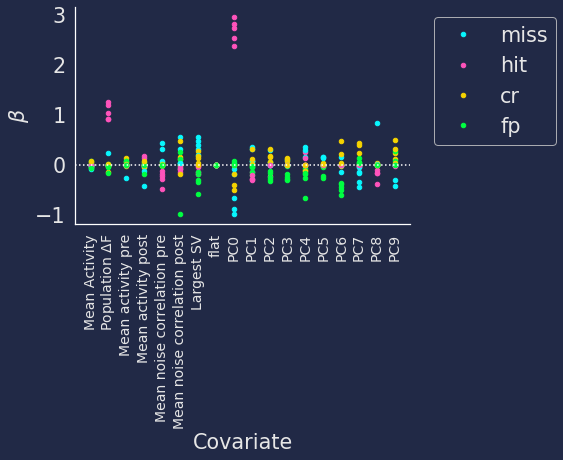

In [62]:
# S2
coefs_s2, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s2')

In [64]:
lm.session.tau_dict.keys()


dict_keys(['all_pre', 'all_post', 'S1_pre', 'S1_post', 'S2_pre', 'S2_post'])

 Cell included from region all


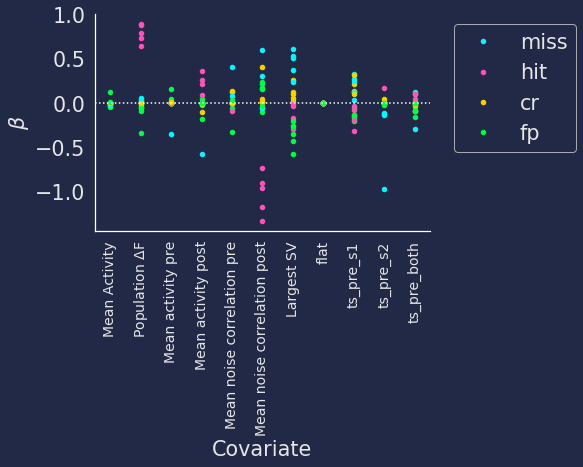

In [91]:

coefs_s2, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='all', 
                                 n_comps_in_partial=0)

 Cell included from region s1
 Cell included from region s1


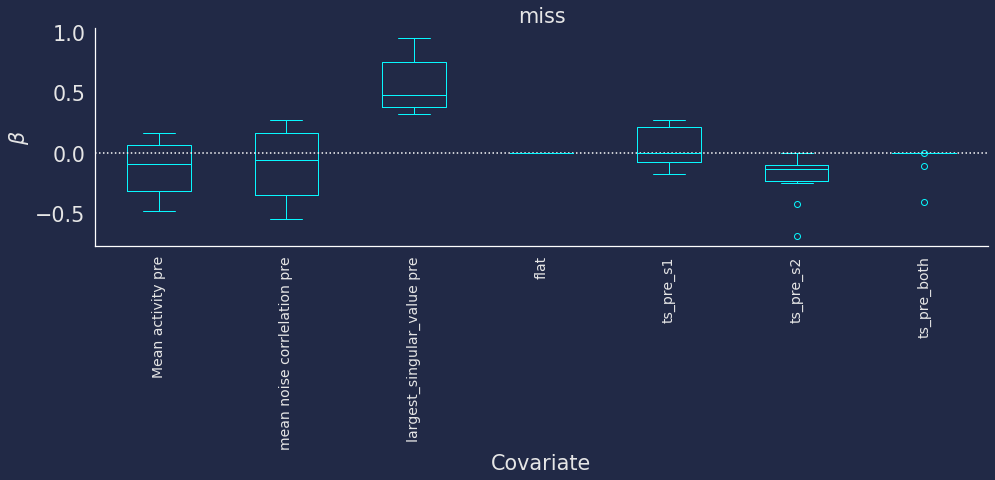

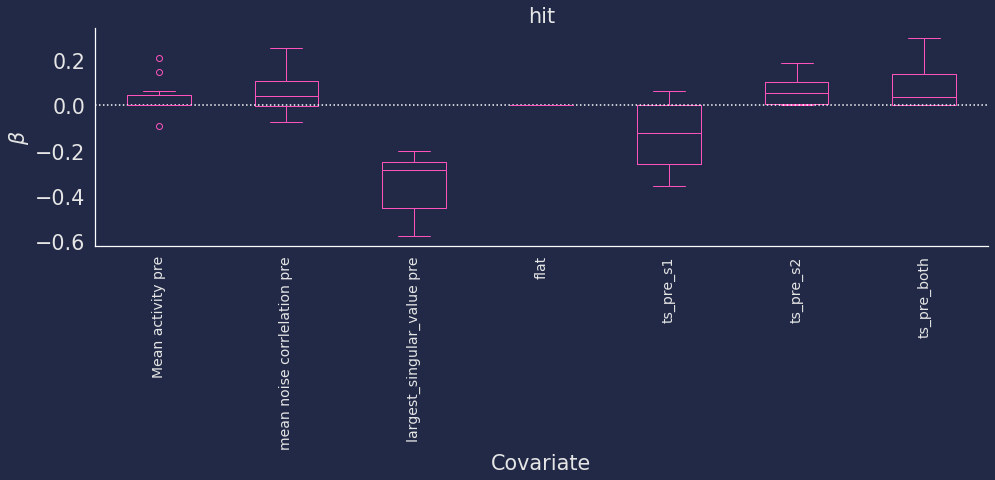

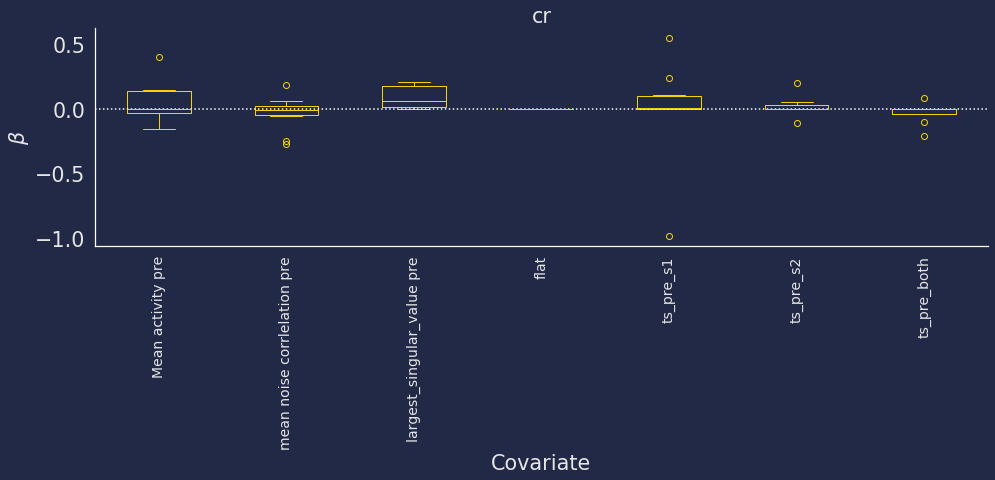

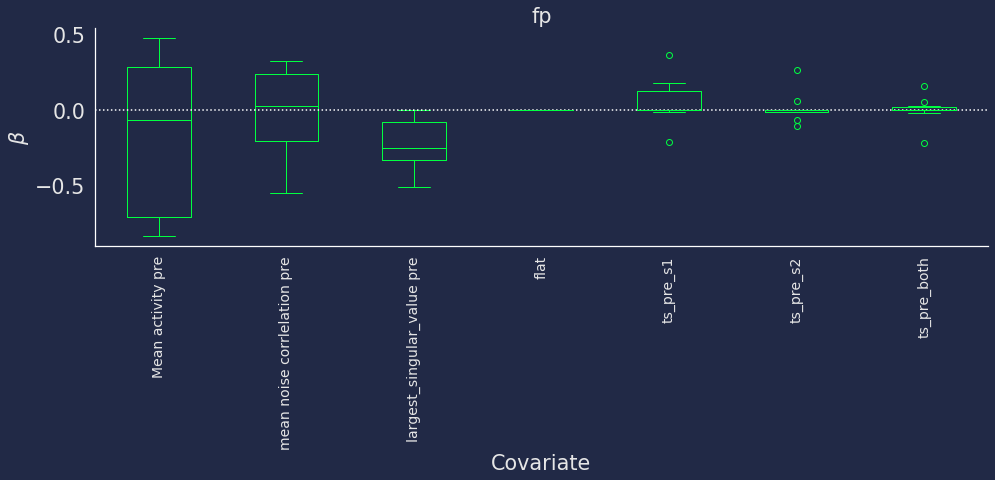

In [104]:
# Across sessions
pas.plot_betas(frames='all', model='partial', multiclass=True, n_comps_in_partial=0, region='s1')

 Cell included from region s2
 Cell included from region s2
 Cell included from region s2


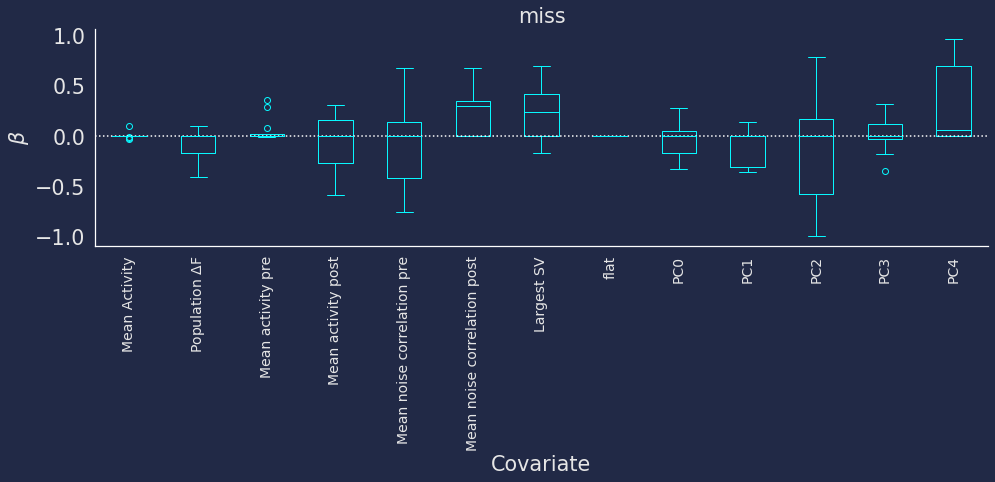

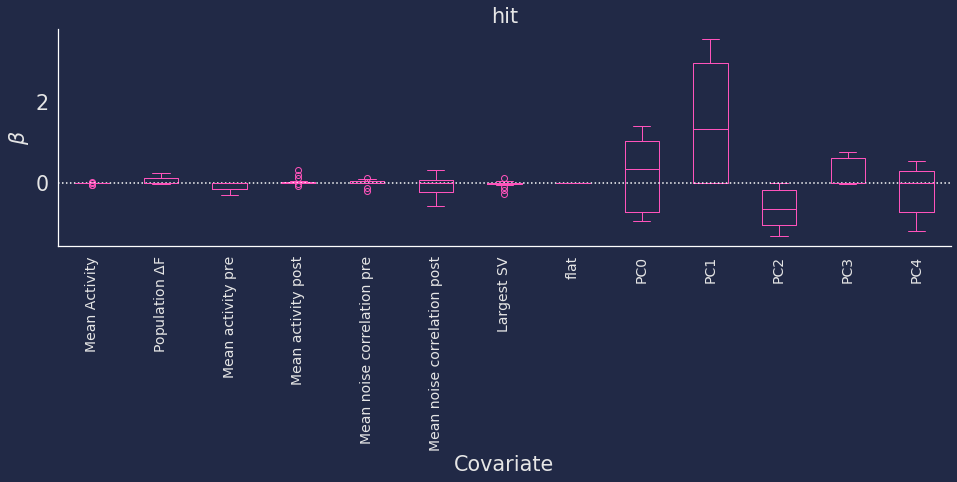

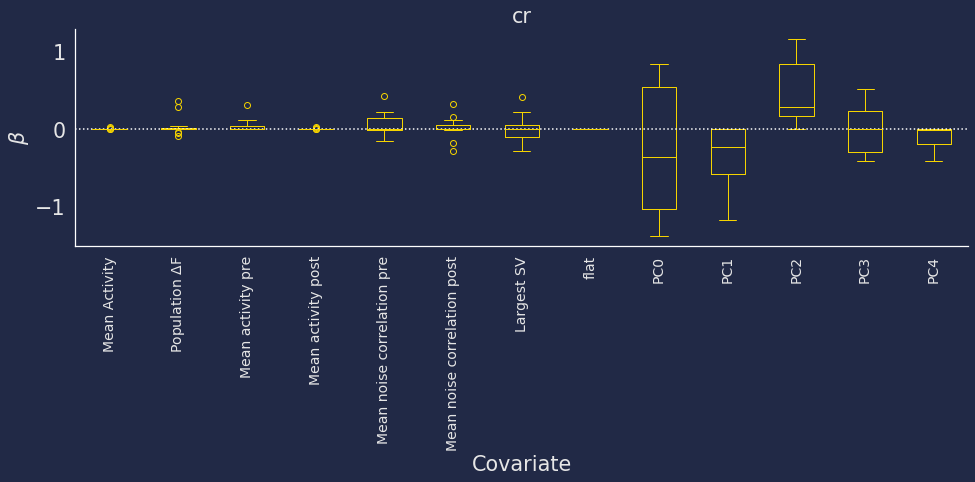

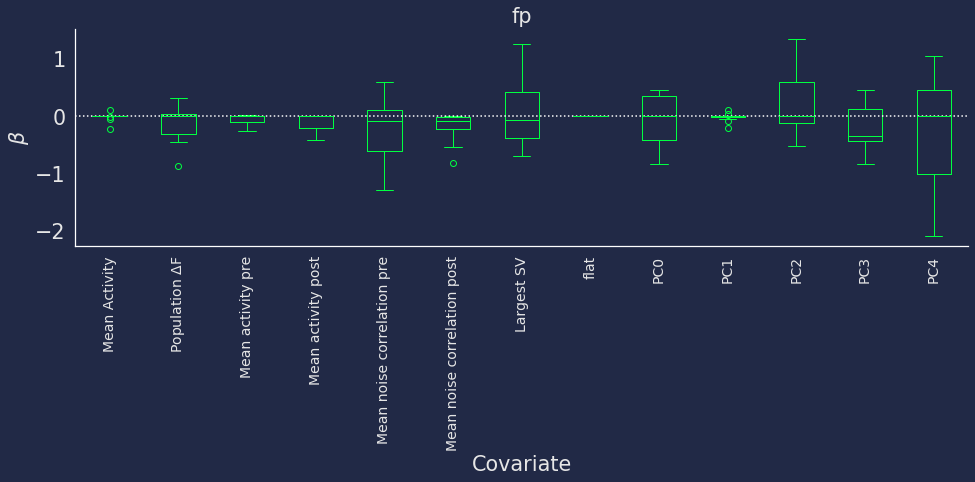

In [15]:
pas.plot_betas(frames='all', model='partial', multiclass=True, n_comps_in_partial=5, region='s2')

### Allows you to eyeball distribution of covariates on different trial types

In [98]:
def get_covariates(lm, region):
    
    X, y = lm.prepare_data('all', 'partial', n_comps_include=0,
                            outcomes=['hit', 'miss', 'fp', 'cr'], 
                            region=region, return_matrix=False)
    return X

In [99]:
def plot_hist(data, color, label, covariate_name, include_bars=False):

    n = 30
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit() # Estimate the densities
    plt.plot(kde.support, kde.density, lw=3, label=label, zorder=10, color=color)
    if include_bars:
        _ = plt.hist(data, n, color=color, density=True)
    plt.xlabel(covariate_name)

In [100]:
s1_covariates = []
s2_covariates = []
for linear_model in pas.linear_models:
    s1_covariates.append(get_covariates(linear_model, 's1'))
    s2_covariates.append(get_covariates(linear_model, 's2'))

 Cell included from region s1
 Cell included from region s2
 Cell included from region s1
 Cell included from region s2


In [101]:
s1_covariates[0].keys()

dict_keys(['trial_mean', 'delta_f', 'mean_pre', 'mean_post', 'corr_pre', 'corr_post', 'largest_singular_value', 'flat', 'ts_s1_pre', 'ts_s2_pre', 'ts_both_pre', 'PCs'])

Text(0, 0.5, 'ts_s1_pre')

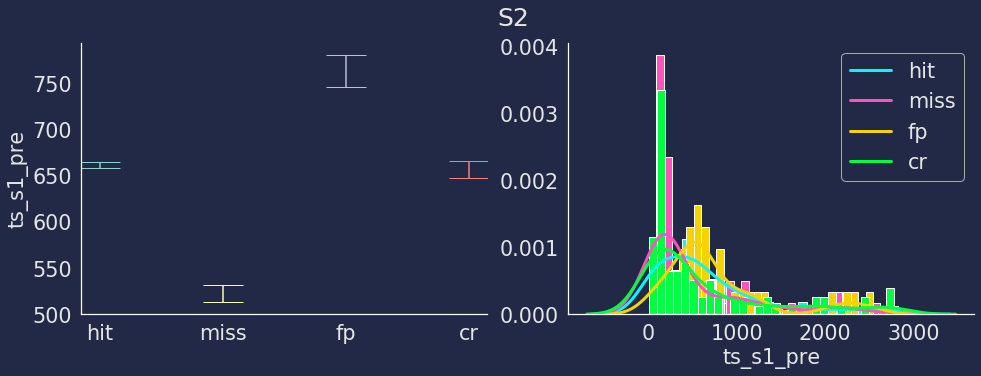

In [102]:
# Build this into pas as a function witht eh previous bit called on init 
region = 's2'

# This is shit
if region == 's1':
    covariates_list = s1_covariates
else:
    covariates_list = s2_covariates

covariate = 'ts_s1_pre'
plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

trials_include = ['hit', 'miss', 'fp', 'cr']

for idx, trial_type in enumerate(trials_include):
    
    trials_use = [linear_model.session.outcome[linear_model.session.nonnan_trials] == trial_type 
                  for linear_model in pas.linear_models]
    
    data = [cov_dict[covariate][trials] for cov_dict, trials in zip(covariates_list, trials_use)]
    
    data = np.concatenate(data)
#     trial_corrs[trial_type] = data
    
    ax1.errorbar([idx], np.mean(data), np.std(data)/len(data), capsize=20, label=trial_type)
    
    plot_hist(data, color=COLORS[idx], label=trial_type, covariate_name=covariate, include_bars=True)
    
plt.legend()
plt.suptitle(region.upper(), fontsize=25)

_ = ax1.set_xticks(np.arange(len(trials_include)))
_ = ax1.set_xticklabels(trials_include)
ax1.set_ylabel(covariate)

In [22]:
def get_signal_corr(lm, region='all'):
    
    # Get signal correlations to 150 cell stim
    # Just easy trials
    
    arr = lm.flu[:, lm.session.photostim==2, :]
    arr = arr[:, :, lm.post]
    arr = arr[lm.region_map[region], :, :]
    tuning_matrix = np.mean(arr, 1)
    
    return np.corrcoef(tuning_matrix) 

In [23]:
off_diagonal = lambda A: A[np.where(~np.eye(A.shape[0],dtype=bool))]


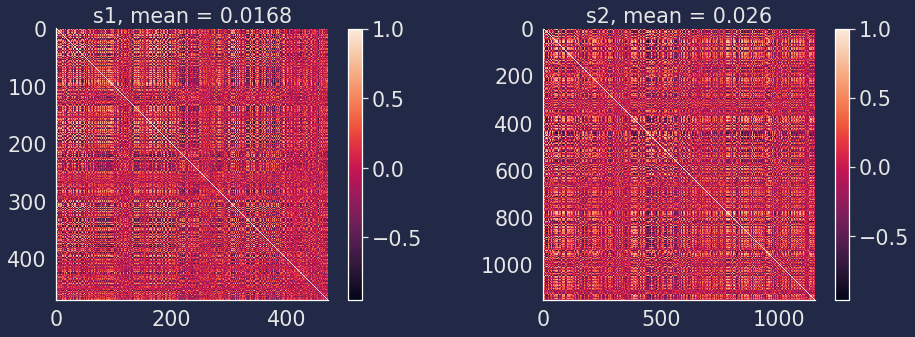

In [24]:
plt.figure(figsize=(16,5))
for idx, region in enumerate(['s1', 's2']):
    plt.subplot(1,2,idx+1)
    signal_corr = get_signal_corr(lm, region=region)
    plt.imshow(signal_corr)
    plt.colorbar()
    plt.title(f'{region}, mean = {round(np.mean(off_diagonal(signal_corr)), 4)}')

### From the Panzeri paper

We quantified across-time and across-neuron pairwise noise correlations separately for trials in which mice made correct orerror choices.In order to discount possible differences in correlation related to trials  numerosity,  we  subsampled  trials  to  equalize  the  number  of  correct  and  error  trials  in  each recorded session. The subsampling procedure was repeated 20 times, and results were averaged over the 20 subsamples

We quantified across-neuron pairwise correlations by computing the Pearson correlation for each pair of neurons recorded in a single session, across trials sharing the same stimulus category. Results were averaged first across stimuli and then across trials subsamples.

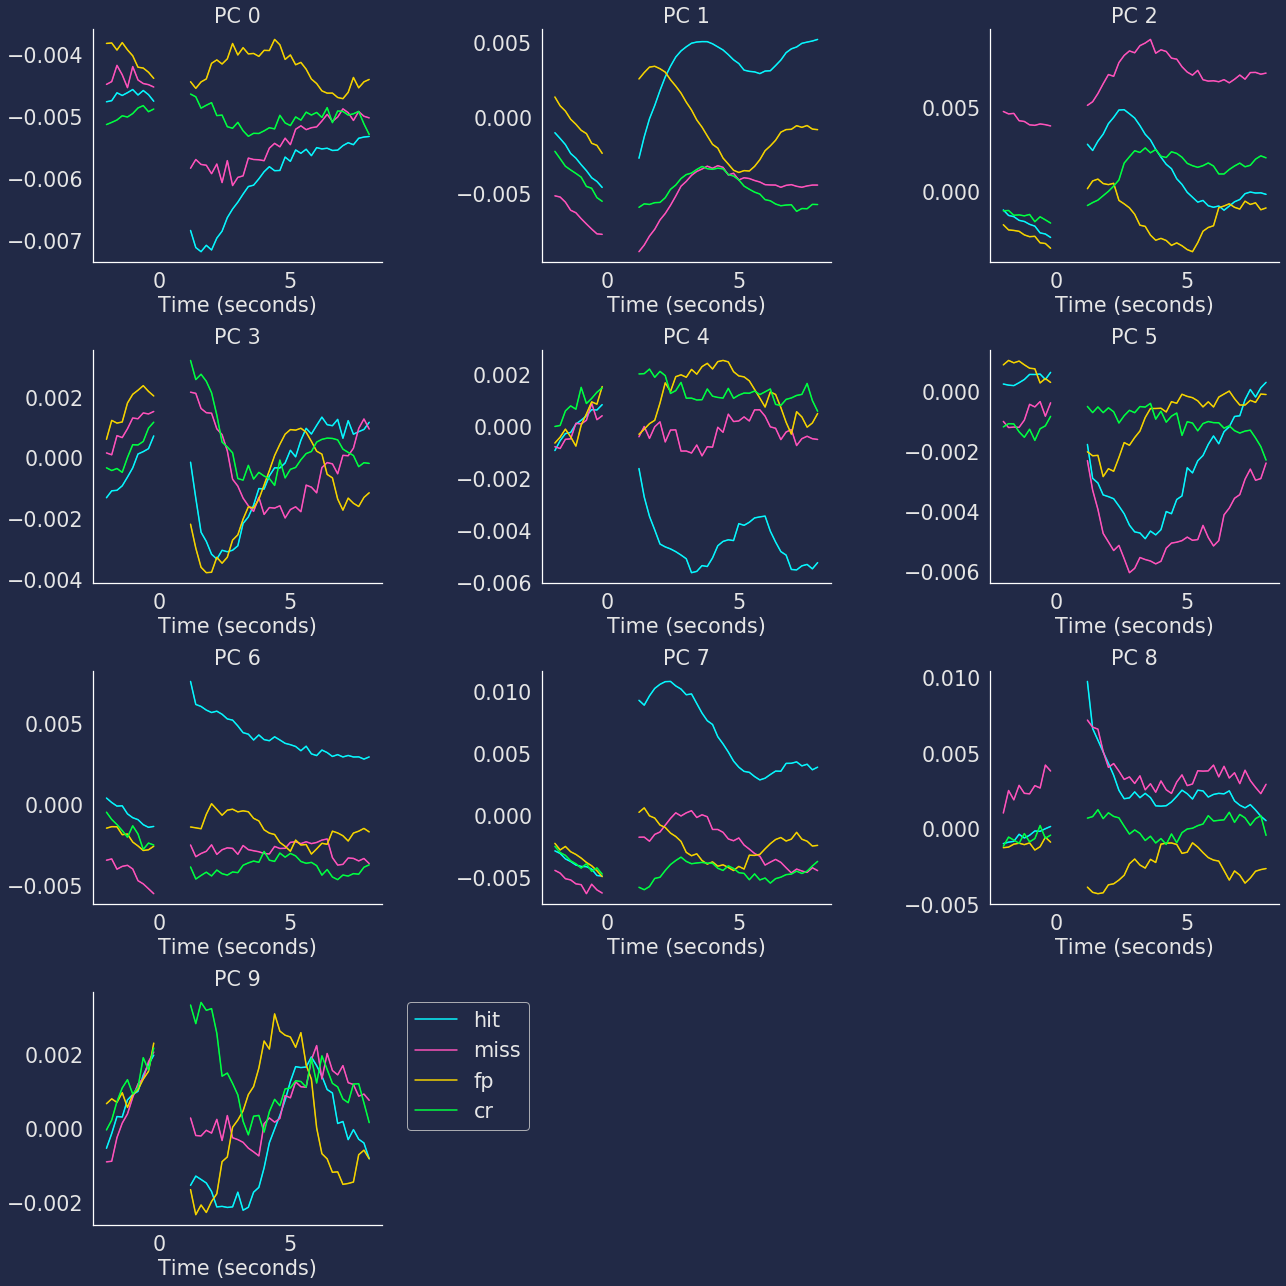

In [25]:
session = lm.session
fig = plt.figure(figsize=(18,18))
for comp in range(10):
    plt.subplot(4,3,comp+1)
    
    comps_arr = session.comps[:, :, session.frames_use]
    comps_arr = comps_arr[comp, :, :]


    for idx, trial_type in enumerate(['hit', 'miss', 'fp', 'cr']):
        arr = comps_arr[session.outcome[session.nonnan_trials]==trial_type, :]
        to_plot = np.mean(arr, 0)
        err_plot = np.std(arr, 0) * 10e-10

        to_plot[~lm.remove_artifact] = np.nan
        plt.plot(lm.times_use, to_plot,
                 color=COLORS[idx], label=trial_type,
                 )
        plt.fill_between(lm.times_use, to_plot-err_plot, to_plot+err_plot, color=COLORS[idx],
                        alpha=0.3)


    if comp==9:
        plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel('Time (seconds)')
    plt.title(f'PC {comp}')

fig.tight_layout(pad=1.0)



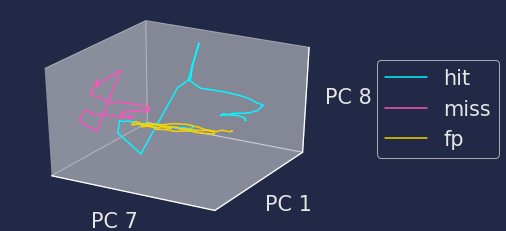

In [26]:
# Get your manifold out
outcomes = session.outcome[session.nonnan_trials]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, outcome in enumerate(['hit', 'miss', 'fp']):
    PCs = lm.session.comps[:, outcomes==outcome, :]
    PCs = np.mean(PCs, 1)
    ax.plot(xs=PCs[1,:], ys=PCs[7,:], zs=PCs[8,:], label=outcome, color=COLORS[idx])
    
ax.set_xlabel('PC 7')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 8')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.legend(bbox_to_anchor=(1.5,0.8))

## Can you decode just from s2 and/or just from pre-frames?

Text(0, 0.5, 'Classification Accuracy')

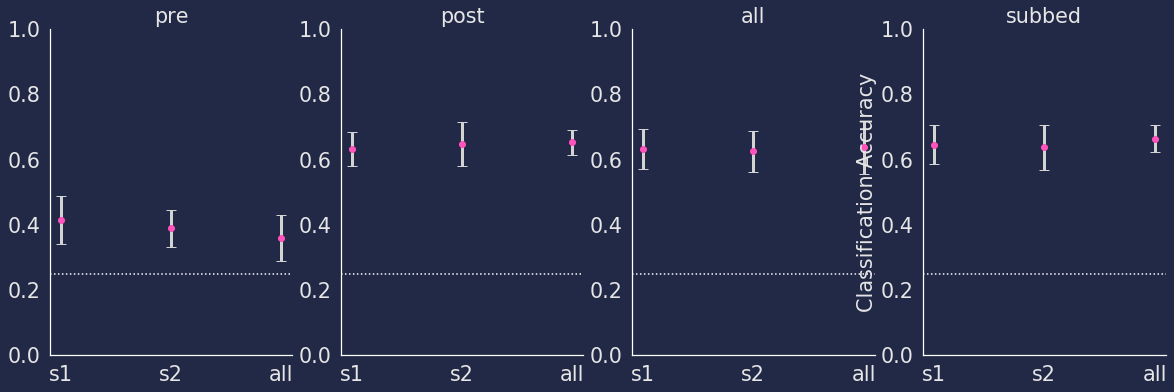

In [28]:
plt.figure(figsize=(20,6))

n_plots = 0
for frames in ['pre', 'post', 'all', 'subbed']:
    n_plots += 1
    plt.subplot(1,4,n_plots)
    pas.compare_regions(frames=frames)
    plt.title(frames)
plt.ylabel('Classification Accuracy')

## Uneven trial numbers can lead to bias, so check bias is not too strong

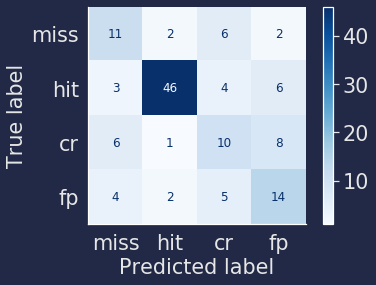

In [29]:
lm = LinearModel(session, pas.times_use)
X, y = lm.prepare_data(model='full', outcomes=['hit', 'miss', 'fp', 'cr'])
acc, std_acc, models = lm.logistic_regression(X, y, 'l1', 0.5, 'saga', compute_confusion=True)

C = np.sum(lm.confusion_matrix, 2)
cmd = ConfusionMatrixDisplay(C, display_labels=lm.encoder.inverse_transform([0,1,2,3]))
cmd.plot(cmap ='Blues')

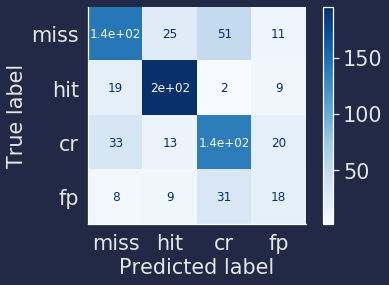

In [30]:
pas.build_confusion_matrix()

## Does the target info of the cell impact the model coefs?

NULL REJECTED!!
14.99% of cells have non-0 coefs


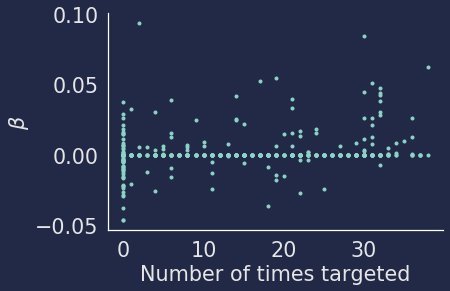

In [31]:
# Re-init the linear_model class with targets
lm = LinearModel(session, pas.times_use, remove_targets=False)
lm.beta_targets_correlation('s1')

NULL REJECTED!!
10.05% of cells have non-0 coefs


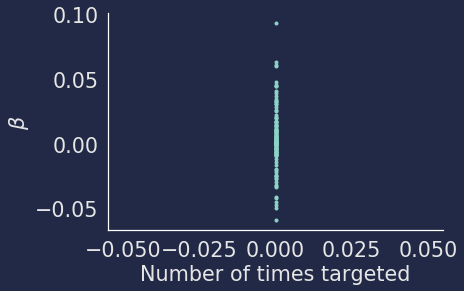

In [32]:
lm.beta_targets_correlation('s2')

(0, 10)

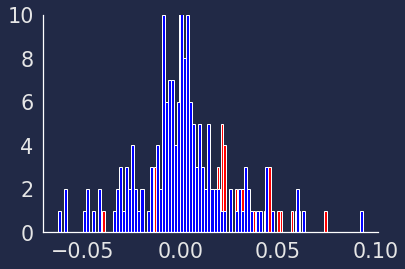

In [34]:
# Distribution of coefs for targets and non targets
plt.hist(lm.hit_coef[lm.ever_targetted], 100, color='red')
plt.hist(lm.hit_coef[~lm.ever_targetted], 100, color='blue')
plt.ylim(0,10)

### Test the hypothesis that PCs should be more correlated on hit trials, or more hit  components are more correlated

In [23]:
def process_coefs(coefs, trial_type='hit'):
    
    # [n_coefs x n_covariates x n_folds]
    coefs = np.dstack(coefs)
    tt_idx = lm.encoder.transform([trial_type])[0]

    trial_coefs = coefs[tt_idx, :, :]
    # Sum across all folds
    trial_coefs = np.sum(trial_coefs, 1)

    # Just get the PCs
    return trial_coefs[-10:]

In [27]:
def PC_correlation(lm, trial_type, trial_average=False):
    
    # Computes single trial correlation between components
    # on a given trial type
    
    frames_use = lm.session.frames_use[lm.post]
    trials = lm.session.outcome[lm.session.nonnan_trials] == trial_type
    # trials = np.repeat(True, s1.shape[1])

    s1 = lm.pca_dict['s1']
    s1 = s1[:, trials, :]
    s1 = s1[:, :, frames_use]

    s2 = lm.pca_dict['s2']
    s2 = s2[:, trials, :]
    s2 = s2[:, :, frames_use]

    trial_max_corr = []
    
    for trial in range(s1.shape[1]):
        s1_comps = s1[:, trial, :]
        s2_comps = s2[:, trial, :]
        
        cunt = []
        for idx, s1_comp in enumerate(s1_comps):
        
            if idx == 10: break  # Just take first 10 comps
                
            pairwise_coors = []
            for idx2, s2_comp in enumerate(s2_comps):
                
                pairwise_coors.append(stats.pearsonr(s1_comp, s2_comp)) 
            
            cunt.append(np.max(pairwise_coors))
            
        trial_max_corr.append(cunt)
    
    return np.array(trial_max_corr).T

 Cell included from region s1
 Cell included from region s2


Text(0, 0.5, 'Model coefs hit trials s2 components')

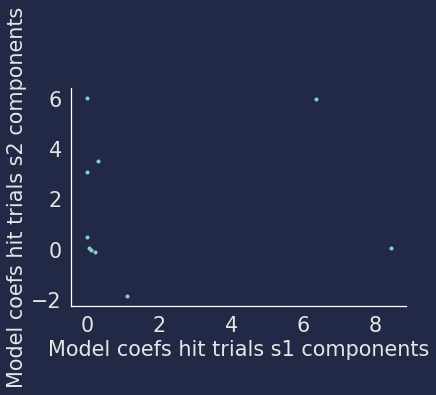

In [28]:
# Due to a bug, I thought the model betas of each component were in the same ranked order, but they
# weren't
coefs_s1, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s1', plot=False)
coefs_s2, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s2', plot=False)
coefs_s1 = process_coefs(coefs_s1)
coefs_s2 = process_coefs(coefs_s2)
plt.plot(coefs_s1, coefs_s2, '.')
plt.xlabel('Model coefs hit trials s1 components')
plt.ylabel('Model coefs hit trials s2 components')

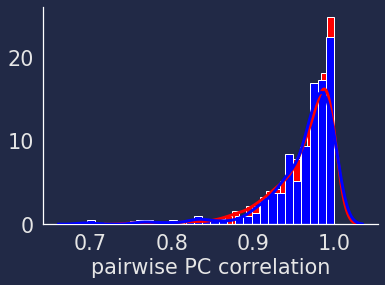

In [37]:
hit = PC_correlation(lm, 'hit', trial_average=False)
miss = PC_correlation(lm, 'miss', trial_average=False)
plot_hist(np.concatenate(hit), 'red', 'hit', 'pairwise PC correlation', include_bars=True)
plot_hist(np.concatenate(miss), 'blue', 'miss', 'pairwise PC correlation', include_bars=True)

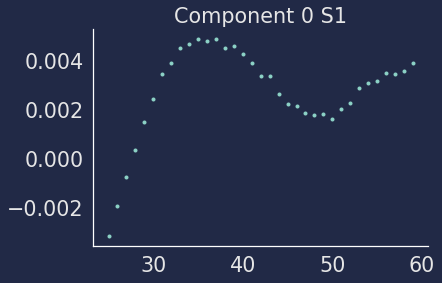

In [40]:
comp_id = 0

trials = lm.session.outcome[lm.session.nonnan_trials] == 'hit'
frames_use = lm.session.frames_use[lm.post]

s1 = lm.pca_dict['s1']
s1 = s1[:, trials, :]
comp = s1[comp_id, :, :]
plt.plot(frames_use, np.mean(comp, 0)[frames_use], '.')
plt.title(f'Component {comp_id} S1')
ylims = plt.gca().get_ylim()

Text(0.5, 1.0, 'Component 0 S2')

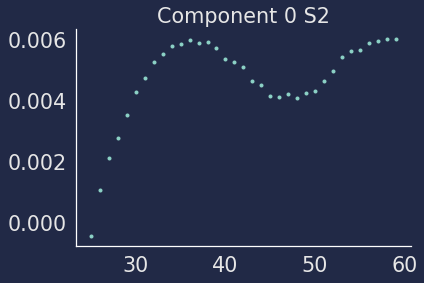

In [41]:
s2 = lm.pca_dict['s2']
s2 = s2[:, trials, :]
comp = s2[comp_id, :, :]
plt.plot(frames_use, np.mean(comp, 0)[frames_use], '.')
plt.title(f'Component {comp_id} S2')
# plt.ylim(ylims)

## This plot motivates the use of multiclass over binary classifier. If you project the hit/miss classifier onto fp vs cr data you can still decode above chance

In [ ]:
means, stds = pas.project_model('all', 'full')
plt.errorbar([0,1,2], means, stds, marker='o', capsize=10, linestyle='')
plt.ylim(0.3, 1)
plt.xticks([0,1,2], ['Hit vs Miss', 'FP vs CR', 'Spont'], rotation=45)
plt.axhline(0.5, linestyle=':')
plt.ylabel('Classification Accuracy')

### Try out the GPFA port

In [ ]:
# A single hit trial
# needs to be x_dim x N
arr = lm.session.behaviour_trials

# The 10th hit trial
trial_idx = np.where(session.outcome[session.nonnan_trials]=='hit')[0][10]
trial = arr[:, trial_idx, :]

dims = factor_analysis.crossvalidate_fa(trial, verbose=True)
